In [1]:
import os 
import sys

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import toast

In [2]:
import scipy.signal as si

In [3]:
import pysm3
import pysm3.units as usm

In [4]:
import astropy.units as u 

In [5]:
env = toast.utils.Environment.get()
comm, procs, rank = toast.get_world()
nthread = os.environ["OMP_NUM_THREADS"]

In [6]:
mem = toast.utils.memreport(msg="(whole node)", comm=comm, silent=False)

Memory usage (whole node)
       total :  503.138 GB
   available :  242.268 GB
     percent :   51.800 % 
     percent :   51.900 %  (after GC)
        used :  211.035 GB
        free :  228.714 GB
      active :   15.429 GB
    inactive :  173.735 GB
     buffers :   46.086 MB
      cached :   63.344 GB
      shared :   17.370 GB
        slab :   39.197 GB



0. Create a template CMB map (sky signal)

In [7]:
NSIDE = 64
lmax = 2*NSIDE

In [8]:
map_CMB_in = hp.read_map(filename='file_CMB_30GHz.FITS',field=None)

In [9]:
map_CMB_in.shape

(3, 49152)

In [10]:
os.listdir('signal')

['MapMaker_rcond.fits',
 'MapMaker_cov.fits',
 'FilterBin_hits.fits',
 'filterbin_signal_hits.fits',
 'MapMaker_map.fits',
 'MapMaker_hits.fits',
 'filterbin_signal_noiseweighted_filtered_map.fits',
 'MapMaker_binmap.fits',
 'FilterBin_noiseweighted_filtered_map.fits']

1. Read maps for the two pipelines : filtering without destriping, destriping without filtering

In [11]:
maps_destriping = {}
for detdata in ["signal", "noise", "atmosphere", "contamination", "full"]:
    maps_destriping['hitmap_'+detdata] = hp.read_map(detdata+"/MapMaker_hits.fits", dtype = float,field = None)
    maps_destriping['covmap_'+detdata] = hp.read_map(detdata+"/MapMaker_cov.fits", dtype = float,field = None)
    maps_destriping['map_'+detdata] = hp.read_map(detdata+"/MapMaker_map.fits", dtype = float,field = None)
    maps_destriping['binmap_'+detdata] = hp.read_map(detdata+"/MapMaker_binmap.fits", dtype = float,field = None)
    maps_destriping['rcondmap_'+detdata] = hp.read_map(detdata+"/MapMaker_rcond.fits", dtype = float,field = None)

In [12]:
maps_filtering = {}
for detdata in ["signal", "noise", "atmosphere", "contamination", "full"]:
    maps_filtering['hitmap_'+detdata] = hp.read_map(detdata+"/filterbin_"+detdata+"_hits.fits", dtype = float,field = None)
    maps_filtering['map_'+detdata] = hp.read_map(detdata+"/filterbin_"+detdata+"_noiseweighted_filtered_map.fits",dtype = float,field = None)

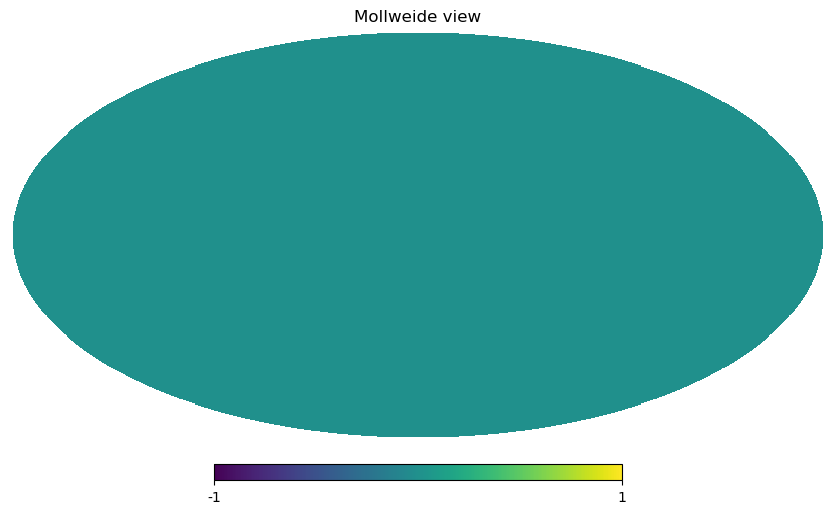

In [13]:
hp.mollview(maps_destriping['hitmap_signal']-maps_destriping['hitmap_full'])

We have retrieved 5 flavours :
1. Detector noise
2. Atmosphere
3. Sky signal (CMB)
4. Contamination (atmosphere+noise)
5. Full

and we want to check if everything has been linear

In [14]:
print(maps_destriping['map_noise'].shape)
print(maps_destriping['map_noise'].shape)

(3, 49152)
(3, 49152)


In [15]:
map_full_reconstruc = maps_destriping['map_noise']+maps_destriping['map_signal']+maps_destriping['map_atmosphere']

In [16]:
map_conta_signal = maps_destriping['map_signal']+maps_destriping['map_contamination']

In [17]:
m = maps_destriping['hitmap_signal']

Mean is 7.458941423905348e-10
Standard deviation is 3.1156588951247303e-07


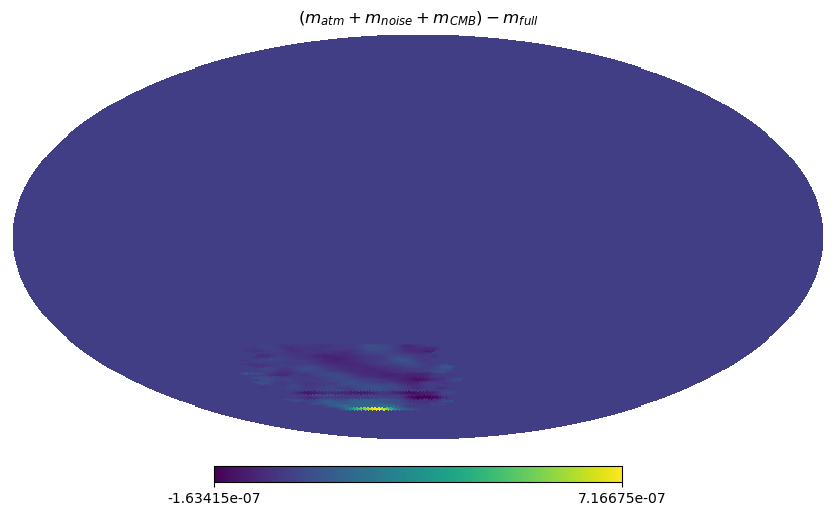

In [18]:
diff_map1 = map_full_reconstruc -maps_destriping['map_full']
#diff_map1[m==0] = hp.UNSEEN

diff_map1.shape

print('Mean is ' + str(np.mean(diff_map1)))

print('Standard deviation is ' + str(np.std(diff_map1)))

hp.mollview(diff_map1[0], #min = -2e-7,max =7e-7, 
            title = r'$(m_{atm}+m_{noise}+m_{CMB})-m_{full}$')

Mean is 5.962956327889579e-10
Standard deviation is 2.898968438606426e-07


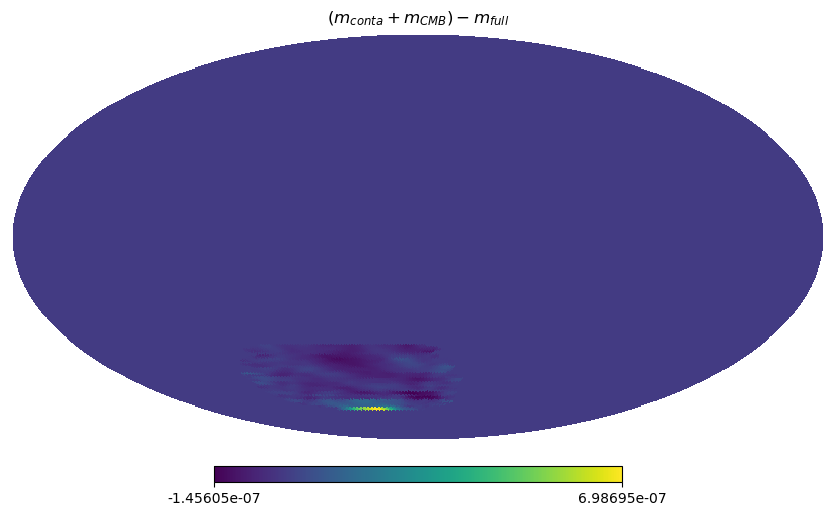

In [19]:
diff_map2 = map_full_reconstruc -map_conta_signal
#diff_map2[m==0] = hp.UNSEEN

diff_map2.shape

print('Mean is ' + str(np.mean(diff_map2)))

print('Standard deviation is ' + str(np.std(diff_map2)))

hp.mollview(diff_map2[0], #min = -2e-7,max =7e-7, 
            title = r'$(m_{conta}+m_{CMB})-m_{full}$')

Compare residuals power spectra

In [20]:
def D_ell(maps, lmax, use_pixel_weights=True):
    l_arr = np.arange(0,lmax+1)
    cl_s = hp.anafast(maps, lmax=lmax,use_pixel_weights=True)
    return (cl_s[:]*l_arr*(l_arr+1)/(2*np.pi))

In [21]:
Dl_atm = D_ell(maps = maps_destriping['map_atmosphere'], lmax=lmax)
Dl_noise = D_ell(maps = maps_destriping['map_noise'], lmax=lmax)
Dl_signal = D_ell(maps = maps_destriping['map_signal'], lmax=lmax)
Dl_full = D_ell(maps = maps_destriping['map_full'], lmax=lmax)
Dl_contamination = D_ell(maps = maps_destriping['map_contamination'], lmax=lmax)


In [22]:
Dl_full1 = D_ell(maps = map_full_reconstruc, lmax=lmax)
Dl_full2= D_ell(maps = map_conta_signal, lmax=lmax)


In [23]:
l_arr = np.arange(0,lmax+1)
l_arr.shape

(129,)

In [24]:
Dl_atm.shape

(6, 129)

In [25]:
hit_mask = np.array(np.where(m<=0))[0]
sky_fraction = 1-(len(hit_mask) / len(m))
print(f"The map covers {sky_fraction:.1%} of the sky")

The map covers 5.1% of the sky


In [27]:
Dl_input = D_ell(map_CMB_in,lmax=lmax)

In [28]:
Dl_input.shape

(6, 129)

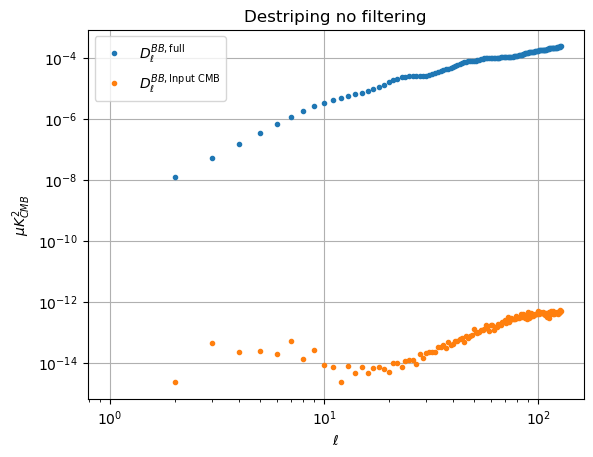

In [29]:
#plt.plot(l_arr, Dl_atm/sky_fraction,'.',label = r'$D_{\ell}^{TT, \text{atmosphere}}$')
#plt.plot(l_arr, Dl_noise/sky_fraction,'.',label = r'$D_{\ell}^{TT, \text{noise}}$')
#pl#t.plot(l_arr, Dl_signal/sky_fraction,'.',label = r'$D_{\ell}^{TT, \text{signal}}$')
#plt.plot(l_arr, Dl_full[0]/sky_fraction,'.',label = r'$D_{\ell}^{TT, \text{full}}$')
#plt.plot(l_arr, Dl_full1[0]/sky_fraction,'.',label = r'$D_{\ell}^{TT, \text{atm+noise+signal}}$')
#plt.plot(l_arr, Dl_full2[0]/sky_fraction,'.',label = r'$D_{\ell}^{TT, \text{conta+signal}}$')
plt.plot(l_arr, Dl_full[2]/sky_fraction,'.',label = r'$D_{\ell}^{BB, \text{full}}$')
#plt.plot(l_arr, Dl_full1[2]/sky_fraction,'.',label = r'$D_{\ell}^{BB, \text{atm+noise+signal}}$')
#plt.plot(l_arr, Dl_full2[2]/sky_fraction,'.',label = r'$D_{\ell}^{BB, \text{conta+signal}}$')
plt.plot(l_arr, Dl_input[2],'.',label = r'$D_{\ell}^{BB, \text{Input CMB} }$')
#plt.plot(l_arr, Dl_signal[2]/sky_fraction,'.',label = r'$D_{\ell}^{BB, \text{Output signal}  }$')
#plt.plot(l_arr, Dl_signal[2]/Dl_input[2],'.',label = r'$D_{\ell}^{BB, \text{Output signal}  }$')
#plt.plot(l_arr, sky_fraction*np.ones(lmax+1),'.',label = r'$D_{\ell}^{BB, \text{Output signal}  }$')

plt.xlabel('$\ell$')
plt.ylabel('$\mu K_{CMB}^2$')
plt.legend(loc = 'best')
plt.xscale('log')
plt.yscale('log')
plt.title('Destriping no filtering')
plt.grid()
plt.show()

In [30]:
hit_full_filt = maps_filtering['hitmap_full']
hit_full_dest = maps_destriping['hitmap_full']

In [31]:
hit_full_dest.shape

(49152,)

In [32]:
map_full_filt = maps_filtering['map_full']
map_full_dest = maps_destriping['map_full']

In [33]:
map_full_filt.shape

(3, 49152)

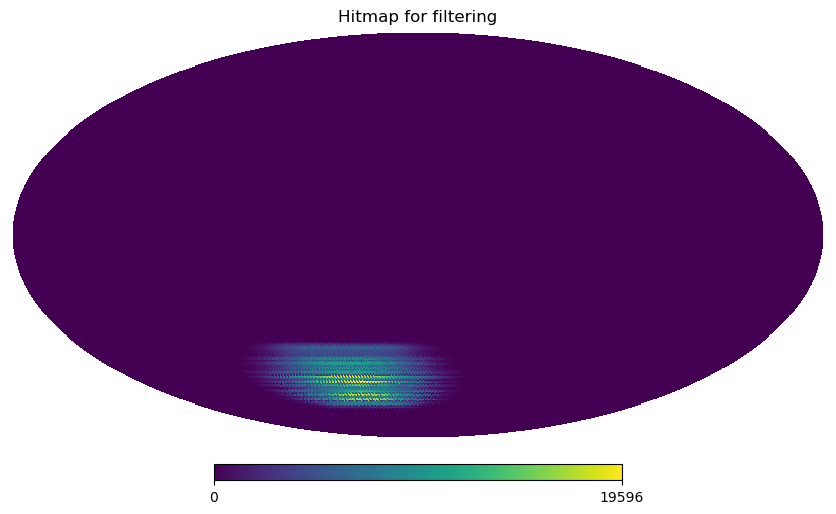

In [79]:
hp.mollview(hit_full_filt,title = 'Hitmap for filtering')

In [47]:
diff_map_filt = map_full_filt -map_CMB_in
diff_map_filt[:,hit_full_filt==0] = hp.UNSEEN
diff_map_dest = map_full_dest - map_CMB_in
diff_map_dest[:,hit_full_dest==0] = hp.UNSEEN


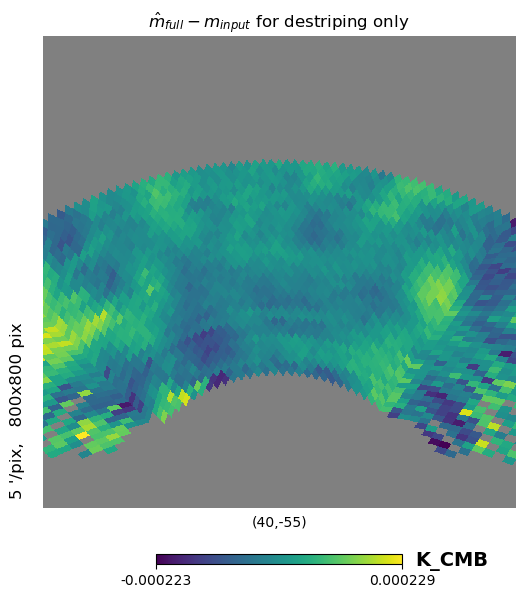

In [113]:
hp.gnomview(diff_map_dest[0],rot = (40,-55),xsize = 800,reso = 5, title = '$\hat{m}_{full}-m_{input}$ for destriping only', unit='K_CMB')

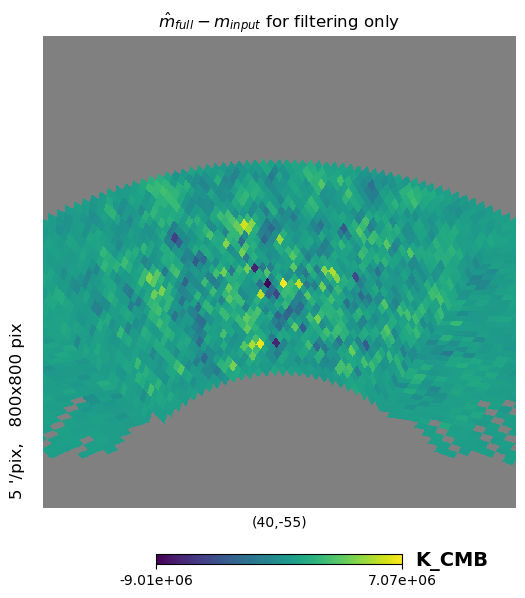

In [112]:
hp.gnomview(diff_map_filt[0],rot = (40,-55),xsize = 800,reso = 5, title = '$\hat{m}_{full}-m_{input}$ for filtering only', unit='K_CMB')